In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

from experiments.data.load_data_util import load_data
from sklearn.utils import shuffle
from rbm.train.kfold_cross_validation import KFoldCrossValidation

from itertools import combinations

import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tqdm import tqdm

from experiments.data.load_data_util import load_data_one_hot_encoding
from experiments.model_evaluate.evaluate_method.evaluate_method_function import plugins_categories_as_one_hot_encoding
from experiments.rbm_experiment.rbm_experiment import RBMExperiment
from rbm.learning.adam import Adam
from rbm.rbmcf import RBMCF
from rbm.sampling.contrastive_divergence import ContrastiveDivergence
from rbm.train.kfold_cross_validation import KFoldCrossValidation

from experiments.data.load_data_util import load_data

from experiments.rbm_experiment.data import Data

tf.reset_default_graph()
session = tf.Session()

original_bag_of_plugins = load_data_one_hot_encoding('../data')
bag_of_plugins = shuffle(original_bag_of_plugins, random_state=42)
kfolds_training_test = KFoldCrossValidation(data=bag_of_plugins, n_splits=5, random_state=42, shuffle=False)

trained_fold = 1
folds = list(kfolds_training_test.split())
index, train, test = folds[trained_fold]

train.head(3)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



,,0,1,2,3,4,5,6,7,8,9,...,107.5,108.5,109.5,110.5,111.5,112.5,113.5,114.5,115.5,116.5
index,id,,,,,,,,,,,,,,,,,,,,,
782.0,7315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1619.0,9672.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
963.0,7753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
path = './data/patches-one-hot-encoding.csv'

rating_size = 117
total_movies = 6
plugins_categories = plugins_categories_as_one_hot_encoding(pd.read_csv("../data/plugins_categories_simplified.csv", sep=",", index_col=['id']), rating_size)

hidden_size = 10000

In [3]:
batch_size, model = 10, RBMCF(total_movies, rating_size, hidden_size=hidden_size, sampling_method=ContrastiveDivergence(1),
                                      learning_rate=Adam(0.05), momentum=0)
model.load(session, f"../results/model/kfold={trained_fold}+kfold-intern=0+batch_size={batch_size}+{model.__str__().replace('/', '+')}/rbm.ckpt")
model = RBMExperiment(model, total_movies)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../results/model/kfold=1+kfold-intern=0+batch_size=10+class=RBMCF+visible_size=702+hidden_size=10000+regularization=NoRegularization-0.0+learning_rate=Adam-0.05-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt


For this sample, the expected label is 21
and the attributes are  [ 85   0   5  64 107 107]


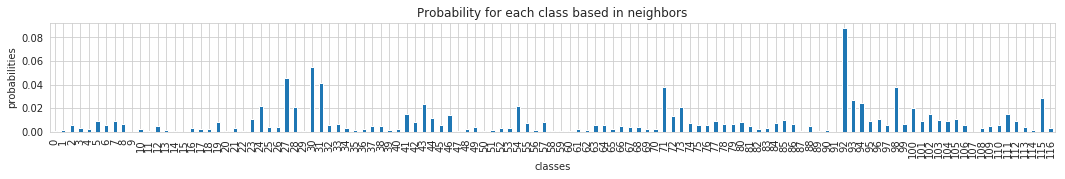

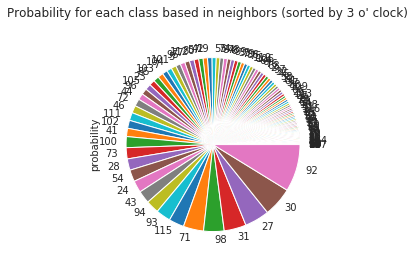

In [4]:
from experiments.model_evaluate.evaluate_method.evaluate_method import complete_missing_classes


def inspect_results(test_x, test_y, y_column):
    print('For this sample, the expected label is', test_y.argmax())
    print('and the attributes are ', test_x.T.reshape((-1, 117)).argmax(axis=1))

    # Model predict_proba remove some labels. Used class labels can obtain from model.classes_
    predict_proba = model.predict_proba(test_x.reshape((-1, 1)), y_column)
    predict_proba = session.run(predict_proba)

    # Probability for each class
    plot = pd.DataFrame(predict_proba.T).plot.bar(legend=False, figsize=(18, 2), title="Probability for each class based in neighbors")
    plot.set_xlabel('classes')
    plot.set_ylabel('probabilities')

    pd.DataFrame(predict_proba.T, columns=['probability']).sort_values('probability').plot.pie(subplots=True, legend=False, title="Probability for each class based in neighbors (sorted by 3 o' clock)")

y_column = 1
element = 0
data = Data(test.values, 6)
X, ys = data.to_missing_movies((y_column,))

inspect_results(X[element, :], ys[0][element, :], y_column)

For this sample, the expected label is 31
and the attributes are  [ 92   0   7  24  27 107]


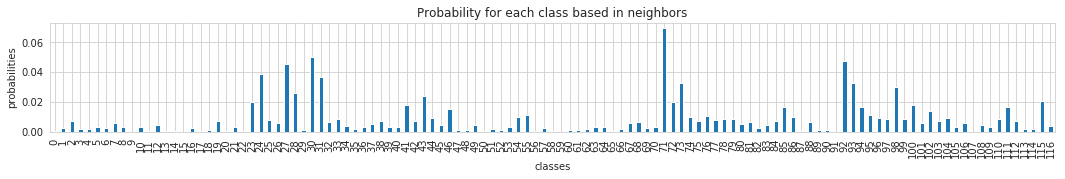

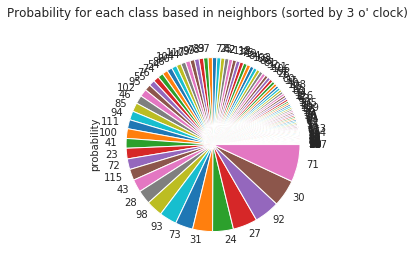

In [5]:
y_column = 1
element = 4
data = Data(test.values, 6)
X, ys = data.to_missing_movies((y_column,))

inspect_results(X[element, :], ys[0][element, :], y_column)

For this sample, the expected label is 72
and the attributes are  [27  0 74 86 30 71]


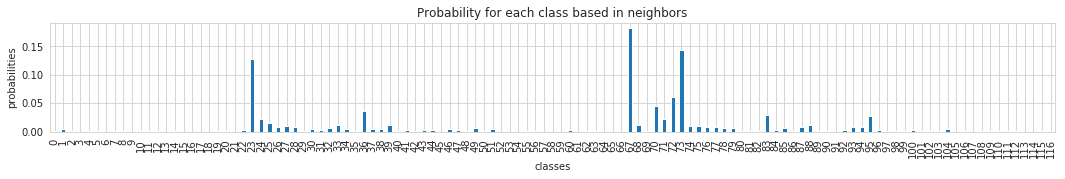

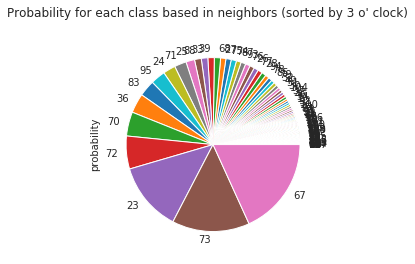

In [6]:
y_column = 1
element = 1
data = Data(test.values, 6)
X, ys = data.to_missing_movies((y_column,))

inspect_results(X[element, :], ys[0][element, :], y_column)

## Data distribution

Plot expected and plot recommendations

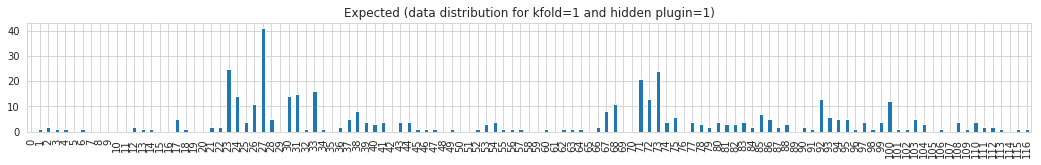

In [7]:
data_distribution = {'data expected': pd.DataFrame(ys[0]).sum(axis=0)}

data_distribution['data expected'].plot.bar(figsize=(18, 2), title=f"Expected (data distribution for kfold=1 and hidden plugin={y_column})")

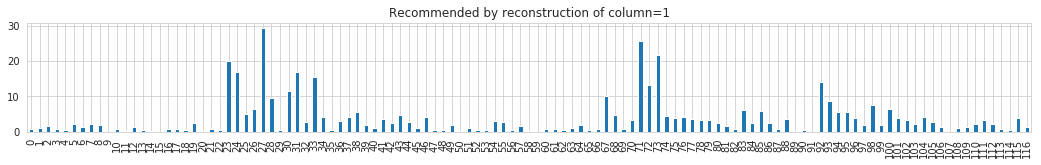

In [8]:
predict_proba = model.predict_proba(X.T, y_column)
predict_proba = session.run(predict_proba)

data_distribution['recommended'] = predict_proba.sum(axis=0)

pd.DataFrame(predict_proba).sum(axis=0).plot.bar(figsize=(18, 2), title=f"Recommended by reconstruction of column={y_column}")

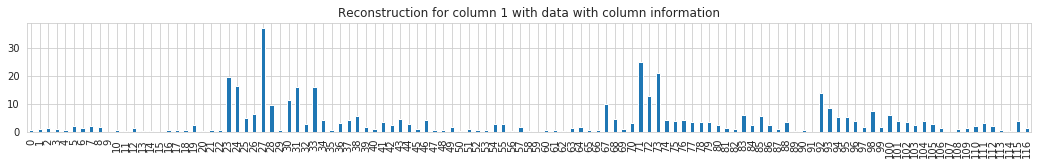

In [9]:
predict_proba = model.predict_proba(test.values.T, y_column)
predict_proba = session.run(predict_proba)

data_distribution['recommended with spoiler'] = predict_proba.sum(axis=0)

pd.DataFrame(predict_proba).sum(axis=0).plot.bar(figsize=(18, 2), title=f"Reconstruction for column {y_column} with data with column information")

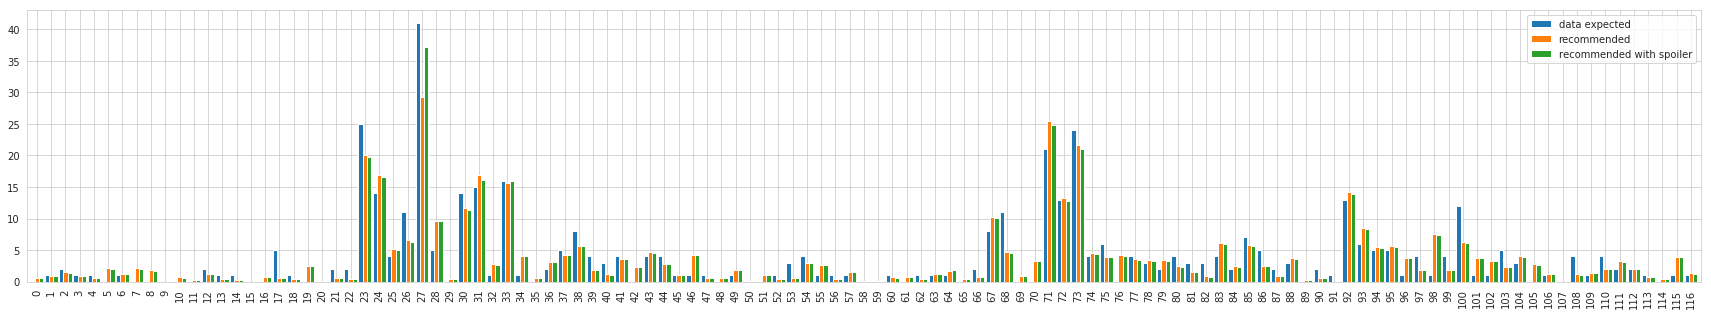

In [10]:
pd.DataFrame(data_distribution).plot.bar(figsize=(30, 5), width=.9)

Ignore all with 27


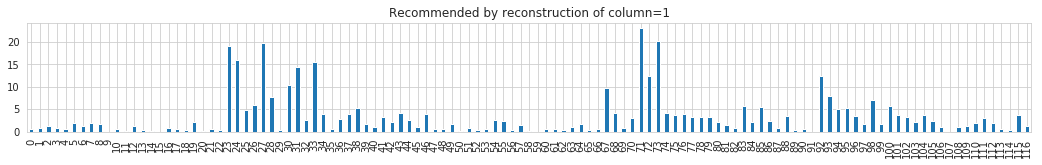

In [39]:
print('Ignore all with 27')

X_without_27 = test.values[ys[0].argmax(axis=1) != 27]
ys_without_27 = ys[0][ys[0].argmax(axis=1) != 27]

predict_proba = model.predict_proba(X_without_27.T, y_column)
predict_proba = session.run(predict_proba)

pd.DataFrame(predict_proba).sum(axis=0).plot.bar(figsize=(18, 2), title=f"When I remove all cases with class 27 for column={y_column}")

## Data distribution - Train

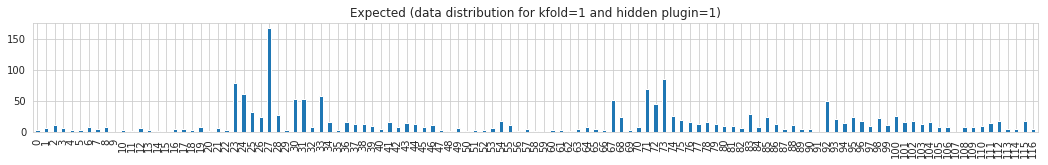

In [23]:
data_train = Data(train.values, 6)
X_train, ys_train = data_train.to_missing_movies((y_column,))

pd.DataFrame(ys_train[0]).sum(axis=0).plot.bar(figsize=(18, 2), title=f"Expected (data distribution for kfold=1 and hidden plugin={y_column})")

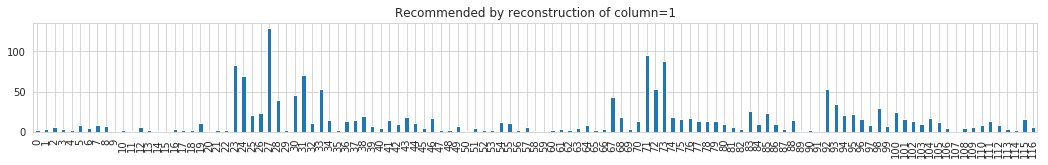

In [24]:
predict_proba = model.predict_proba(X_train.T, y_column)
predict_proba = session.run(predict_proba)

pd.DataFrame(predict_proba).sum(axis=0).plot.bar(figsize=(18, 2), title=f"Recommended by reconstruction of column={y_column}")